In [170]:
# Import
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

Memory growth enabled for GPUs


# Training (Nitrate)

In [171]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [ ]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 32  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[128],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=20,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )

# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 5e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

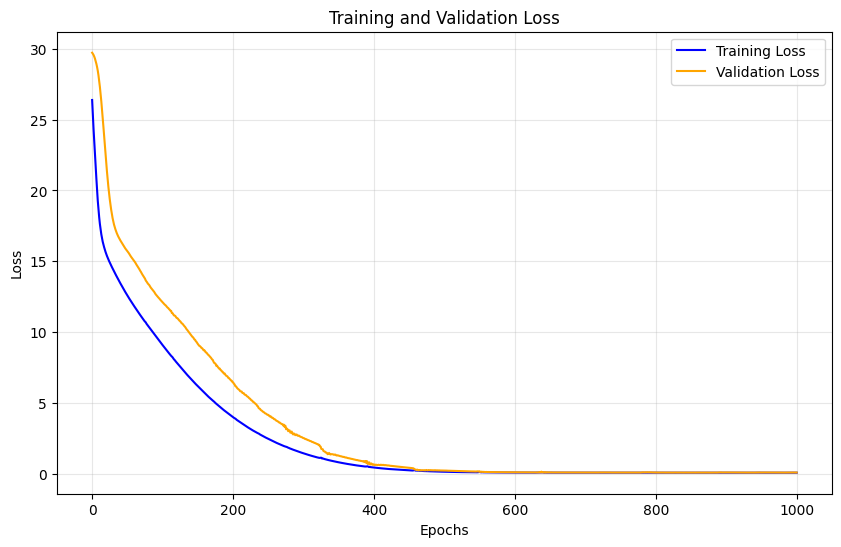

In [173]:
plot_loss(history)

# Prediction & Performance

In [360]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [361]:
def find_outliers_iqr(series, iqr_factor=1.5):
    """
    series: pd.Series
    iqr_factor: 1.5가 기본. (3.0으로 올리면 더 엄격히 outlier 판단)
    
    Returns
    -------
    pd.Series (dtype=bool), True이면 이상치
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (iqr_factor * IQR)
    upper_bound = Q3 + (iqr_factor * IQR)
    
    outliers_mask = (series < lower_bound) | (series > upper_bound)
    return outliers_mask

In [362]:
'''
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 0  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

o3_cols = [col for col in emis_ctrl_2019_10.columns if "O3_ALL" in col]
df_o3 = emis_ctrl_2019_10[o3_cols].copy()

overall_outliers_mask = np.zeros(len(df_o3), dtype=bool)

for col in df_o3.columns:
    mask_outliers_col = find_outliers_iqr(df_o3[col], iqr_factor=1.5)
    # outlier로 판정된 행(True)는 OR(|=)로 합치기
    overall_outliers_mask |= mask_outliers_col

# 최종적으로 'O3 컬럼 중 하나라도 IQR 범위를 벗어난' 행
df_outliers_o3 = df_o3[~overall_outliers_mask]

print("O3 열 중 하나라도 outlier로 판정된 행 개수:", len(df_outliers_o3))
print(df_outliers_o3.head())

emis_ctrl_2019_10 = emis_ctrl_2019_10[~overall_outliers_mask]  # ~ : 반전
print("이상치 제외 후 df_inliers 크기:", emis_ctrl_2019_10.shape)

# =============

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
conc_data = conc_data[~overall_outliers_mask]
print("이상치 제외에 맞춘 Label 크기:", conc_data.shape)

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()
'''

'\ntest_split = 0.4  # 테스트 데이터 비율 (20%)\nrandom_seed = 0  # 랜덤 시드\nmodel = tf.keras.models.load_model(\'/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model\')\n\npred_emis_data = []\npred_time_data = []\npred_boundary_data = []\n\n# Load Test Data\nemis_ctrl_2019_10 = pd.read_csv(\n    \'/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv\')\nemis_ctrl_2019_10[\'Boundary\'] = 1.0\n\no3_cols = [col for col in emis_ctrl_2019_10.columns if "O3_ALL" in col]\ndf_o3 = emis_ctrl_2019_10[o3_cols].copy()\n\noverall_outliers_mask = np.zeros(len(df_o3), dtype=bool)\n\nfor col in df_o3.columns:\n    mask_outliers_col = find_outliers_iqr(df_o3[col], iqr_factor=1.5)\n    # outlier로 판정된 행(True)는 OR(|=)로 합치기\n    overall_outliers_mask |= mask_outliers_col\n\n# 최종적으로 \'O3 컬럼 중 하나라도 IQR 범위를 벗어난\' 행\ndf_outliers_o3 = df_o3[~overall_outliers_mask]\n\nprint("O3 열 중 하나라도 outlier로 판정된 행 개수:", len(df_outliers_o3))\nprint(df_outliers_o3.head())\n\nemis_ctrl_201

In [ ]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

o3_cols = [col for col in emis_ctrl_2019_10.columns if "O3_ALL" in col]
df_o3 = emis_ctrl_2019_10[o3_cols].copy()

overall_mask = np.zeros(len(emis_ctrl_2019_10), dtype=bool)
for col in emis_ctrl_2019_10.columns:
    # 수치형 컬럼에만 적용(문자형, 날짜형 제외)
    if pd.api.types.is_numeric_dtype(emis_ctrl_2019_10[col]):
        mask_col = find_outliers_iqr(emis_ctrl_2019_10[col], iqr_factor=1.5)
        overall_mask |= mask_col  # OR 연산

# 최종 이상치 행
df_outliers = emis_ctrl_2019_10[overall_mask]
print("전체 컬럼 중 하나라도 이상치인 행:", len(df_outliers))

emis_ctrl_2019_10 = emis_ctrl_2019_10[~overall_mask]  # ~ : 반전
print("이상치 제외 후 df_inliers 크기:", emis_ctrl_2019_10.shape)

# =============

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
conc_data = conc_data[~overall_mask]
print("이상치 제외에 맞춘 Label 크기:", conc_data.shape)

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

전체 컬럼 중 하나라도 이상치인 행: 5
이상치 제외 후 df_inliers 크기: (114, 86)
이상치 제외에 맞춘 Label 크기: (114, 82, 67, 1)
2/2 [==============================] - 1s 11ms/step


In [364]:
X_emis_test[38]

array([1.16985112, 0.747613  , 1.32067729, 1.31329615, 0.57291991,
       0.97306017, 1.25960598, 1.16209978, 1.09753432, 1.29811992,
       1.39233575, 1.3061789 , 1.01188527, 1.16780748, 0.98105541,
       0.67380752, 1.0192175 , 0.80748223, 0.83068957, 1.06017938,
       1.13736956, 1.14766074, 0.66637589, 0.89173405, 1.15441646,
       0.99566358, 1.02768476, 1.36935314, 0.91070449, 0.98671286,
       1.26000599, 1.3055484 , 0.76903728, 1.24920172, 1.2895833 ,
       0.80867354, 1.13825918, 1.24343596, 0.84208086, 1.18210355,
       0.9684886 , 0.9224894 , 0.67341221, 1.05877869, 1.24001114,
       1.11207926, 1.18192395, 0.62286315, 0.8998117 , 1.25626158,
       0.72866329, 0.75935929, 0.98375909, 1.01865691, 1.26384366,
       0.69240302, 0.83690998, 0.97268973, 0.88228046, 1.35325516,
       0.82597236, 0.89373434, 0.59418921, 0.83468512, 1.40404784,
       0.96150097, 1.022451  , 0.907084  , 1.12933832, 1.48442265,
       0.79582803, 1.09341486, 0.81805052, 0.74951955, 1.11460

In [365]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(46, 82, 67)
(46, 82, 67)
(46, 82, 67)
(46, 82, 67)


In [380]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=100, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    # y_err_std = np.std(y_norm_err, axis=1)  # (48,)
    return y_err_mean, y_err_std

In [367]:
def remove_outliers_by_relative_error(y_true, y_pred, max_rel_err=0.5):
    """
    상대 오차(max_rel_err)를 넘는 위치를 outlier로 간주하고 제외.
    원본 데이터 shape을 복원하기 위해 inliers(boolean index)도 반환.
    """
    # 1) 원본 shape과 flatten
    original_shape = y_true.shape
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    
    # 2) 상대 오차 계산
    epsilon = 1e-8
    rel_err = np.abs(y_true_flat - y_pred_flat) / (y_true_flat + epsilon)
    
    # 3) inliers 찾기
    inliers = (rel_err <= max_rel_err)
    
    # 4) inlier만 골라 반환
    y_true_in = y_true_flat[inliers]
    y_pred_in = y_pred_flat[inliers]
    
    return y_true_in, y_pred_in, inliers, original_shape

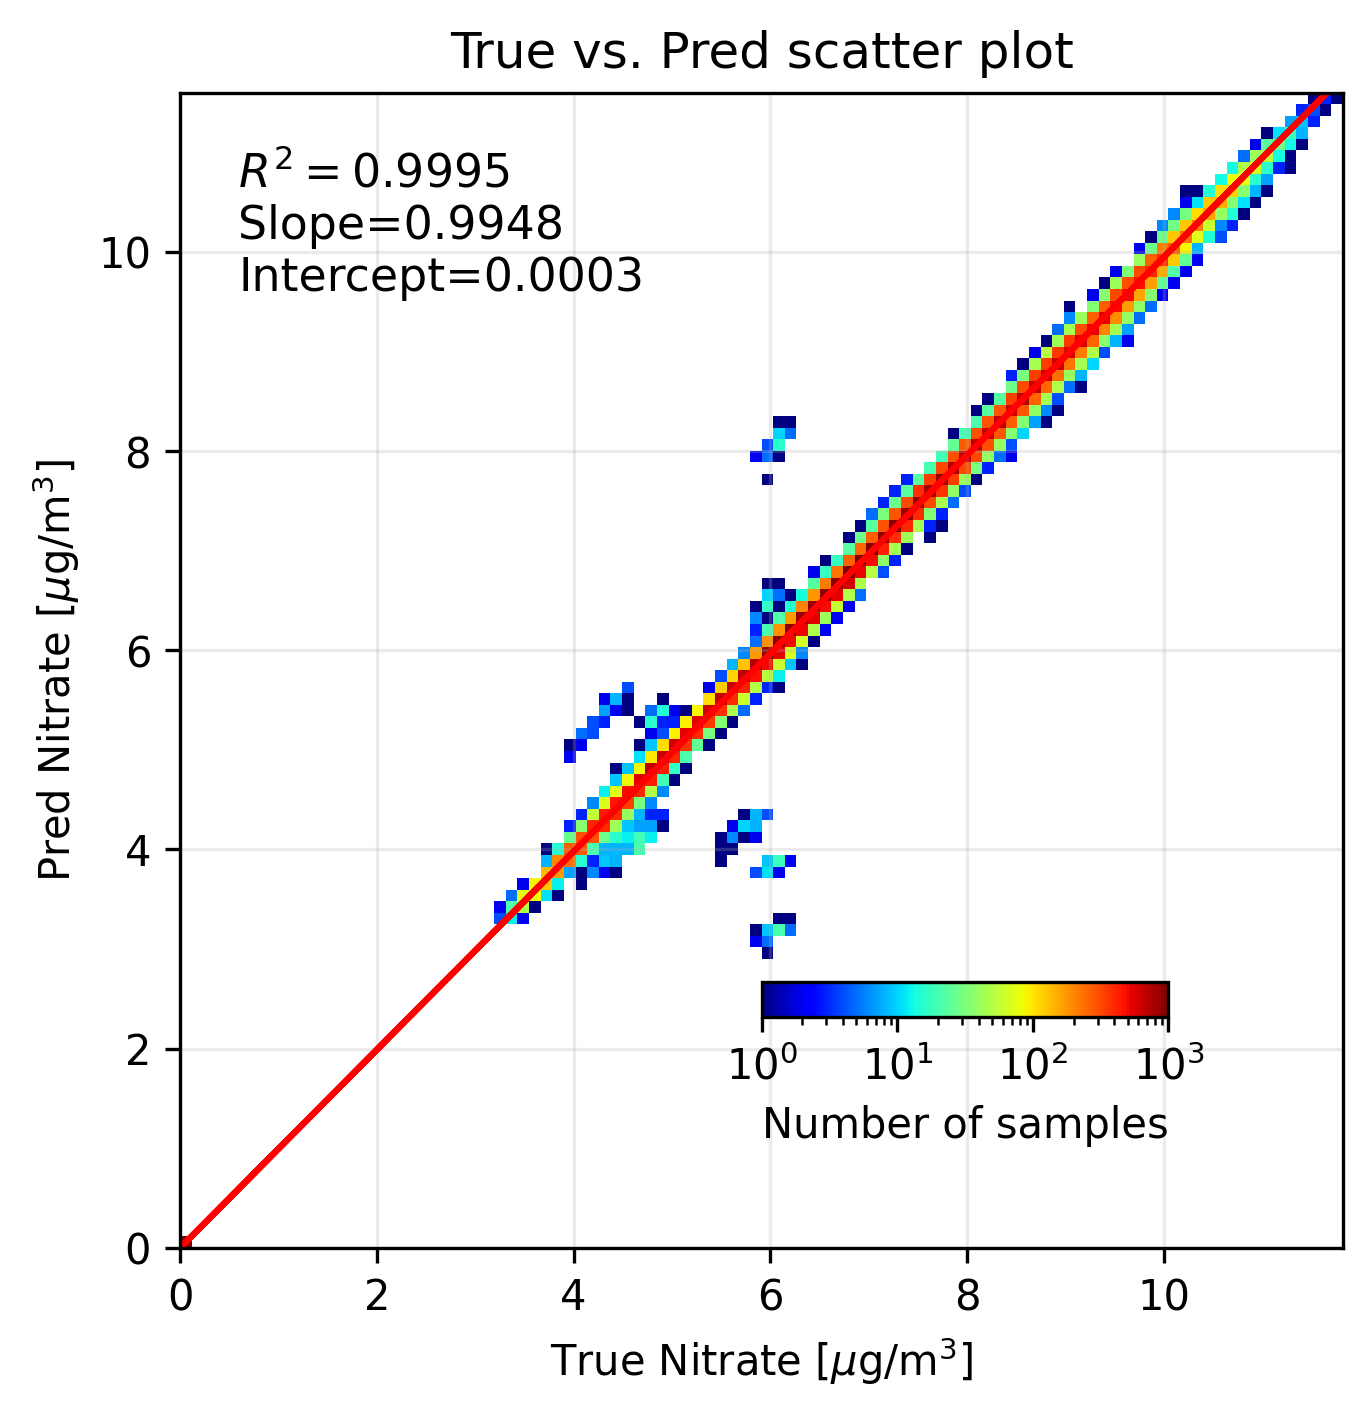

In [381]:
y_true_in, y_pred_in, inliers, original_shape = remove_outliers_by_relative_error(
    true_conc_map_w_lines, pred_conc_map_w_lines,
    max_rel_err=1
)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_in, y_pred_in)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

In [369]:
y_pred_restored = np.full(np.prod(original_shape), np.nan, dtype=np.float32)
y_pred_restored[inliers] = y_pred_in
y_pred_restored = y_pred_restored.reshape(original_shape)
# y_pred_restored = y_pred_restored[0]

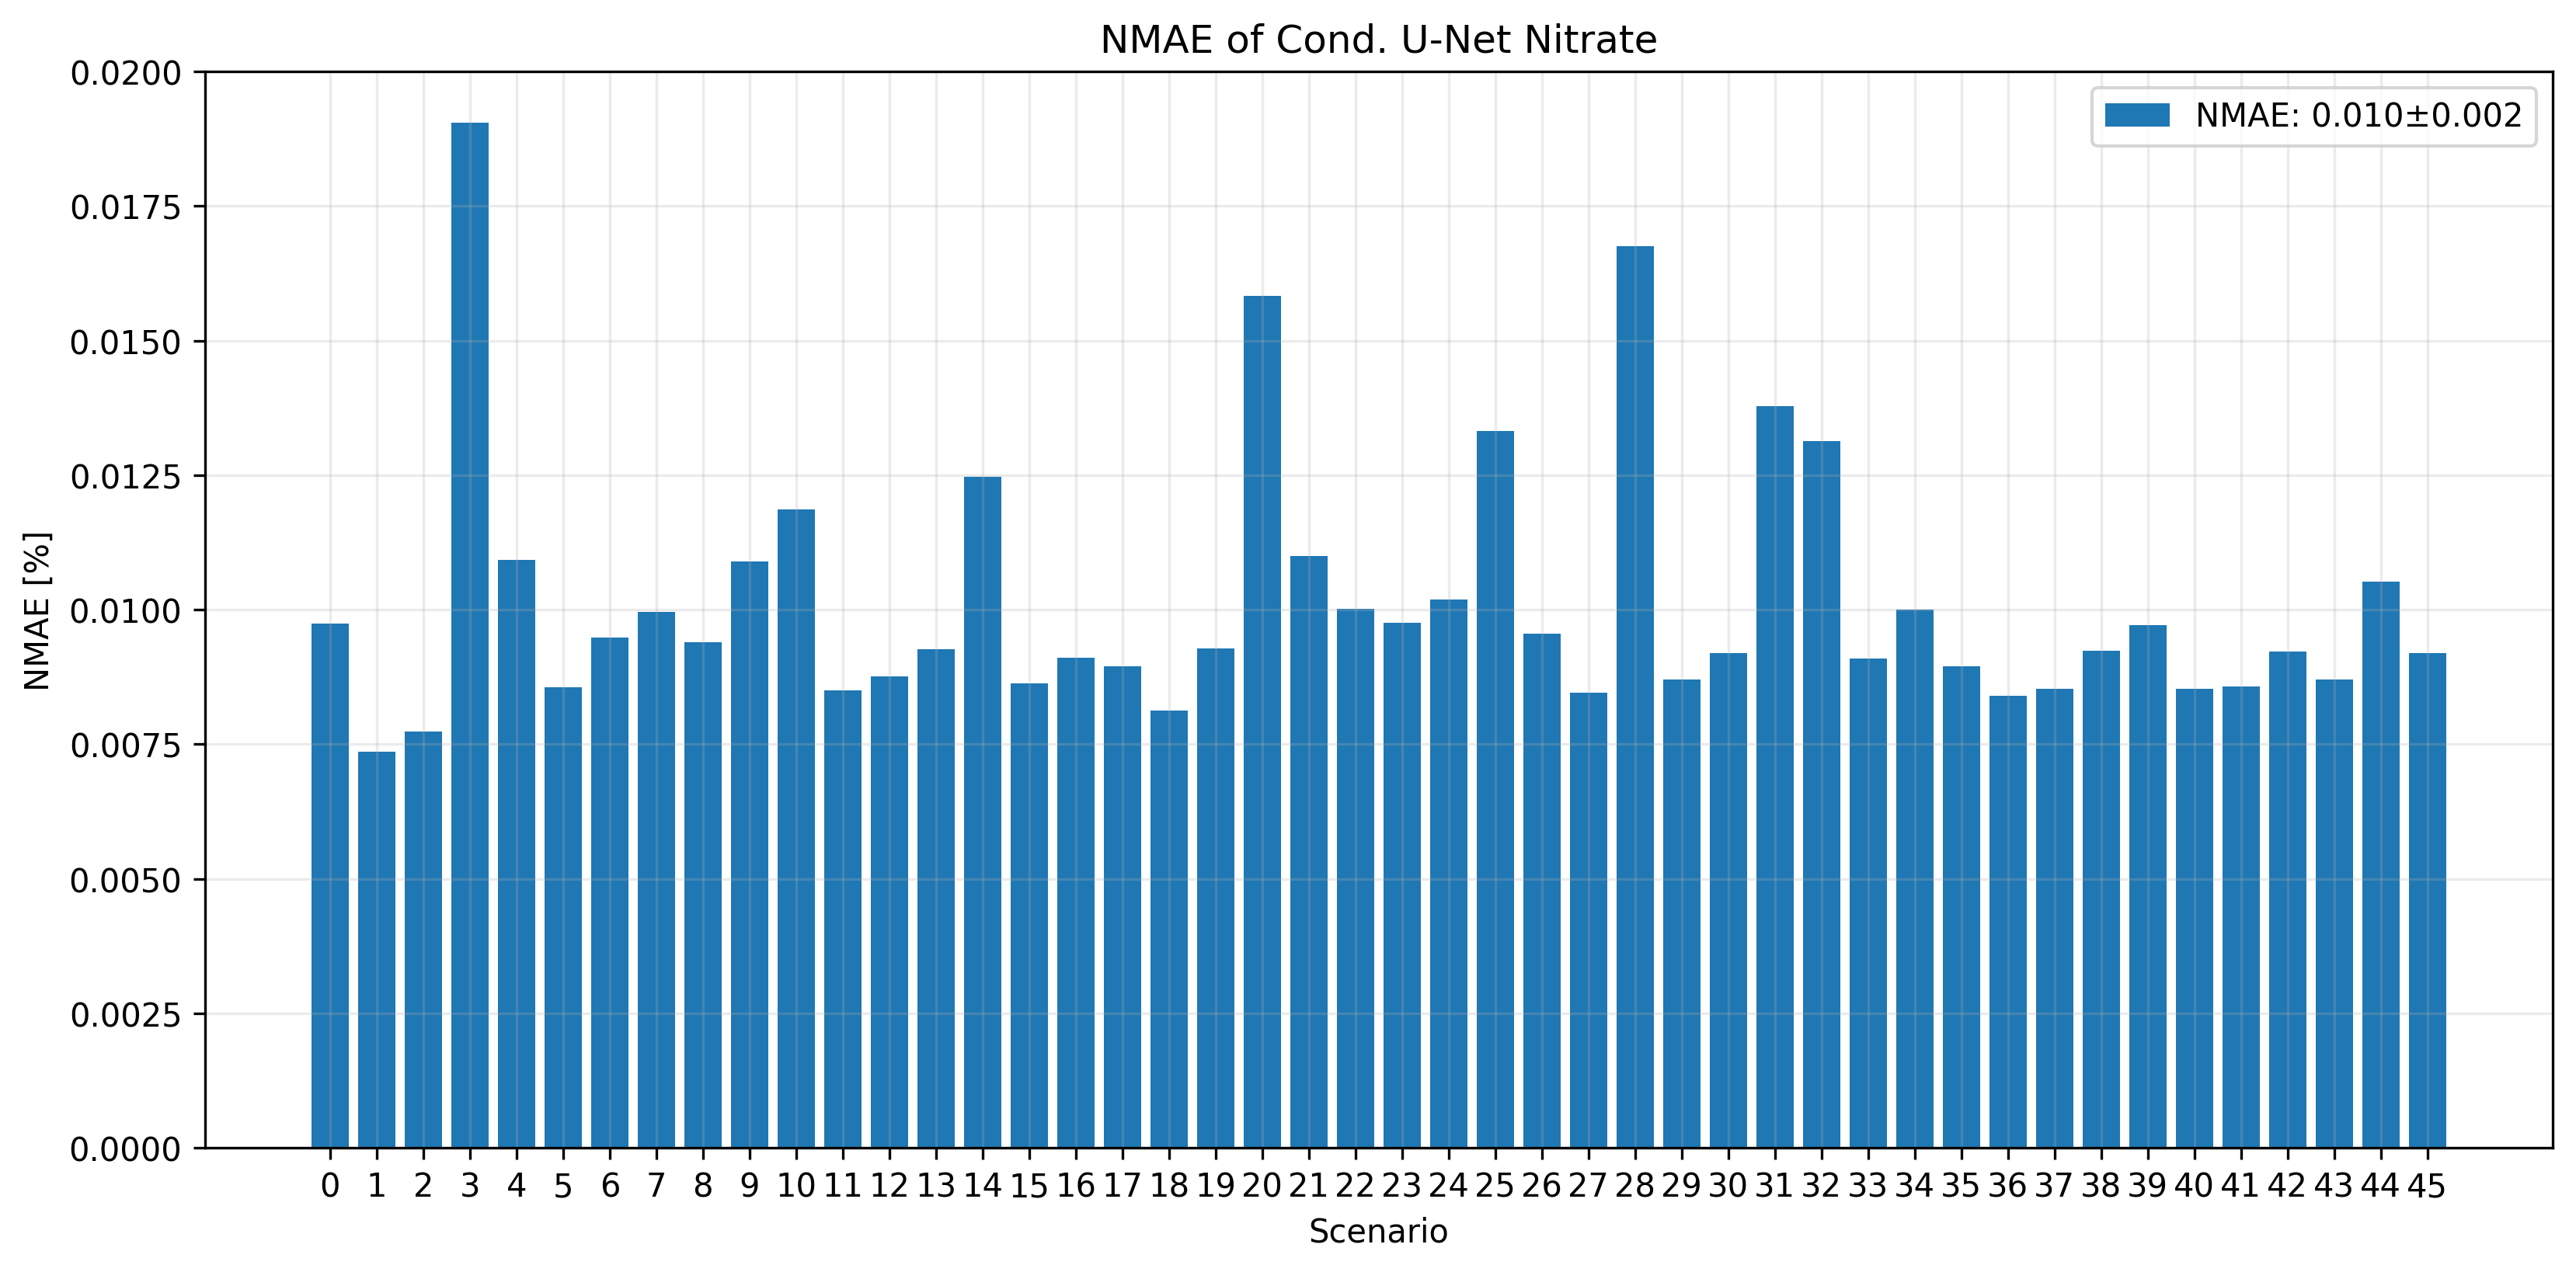

In [370]:
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [371]:
print(get_score((y_test[37].reshape(82,67)), y_pred[37]))

(array([0.00734599, 0.00962067, 0.01066821, 0.00869951, 0.00847038,
       0.01021768, 0.01024377, 0.01103476, 0.00978066, 0.00932281,
       0.01088969, 0.0101443 , 0.0116659 , 0.01015145, 0.01661324,
       0.02248899, 0.02201538, 0.01322936, 0.01364167, 0.02508138,
       0.03280209, 0.02437968, 0.01194644, 0.00942647, 0.00863048,
       0.0113574 , 0.00804802, 0.0110927 , 0.01694704, 0.02326867,
       0.01976438, 0.01249776, 0.00985319, 0.00954568, 0.01038724,
       0.00889855, 0.00790753, 0.00857981, 0.01070242, 0.00878954,
       0.01046386, 0.00834053, 0.00735502, 0.00792042, 0.00623875,
       0.00703289, 0.00960707, 0.01277724, 0.01195942, 0.0083045 ,
       0.00776094, 0.00848892, 0.00803733, 0.00834764, 0.00619251,
       0.01097701, 0.01296715, 0.01428734, 0.00898676, 0.01005404,
       0.01855257, 0.02200899, 0.01908589, 0.01176033, 0.02978795,
       0.06211061, 0.06683088, 0.03678422, 0.01460798, 0.02369318,
       0.03371613, 0.02739109, 0.01610681, 0.01892512, 0.0348

[37]


/tmp/ipykernel_1931213/4034451116.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1931213/4034451116.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1931213/4034451116.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1931213/4034451116.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1931213/4034451116.py:67: UserWarning: set_ti

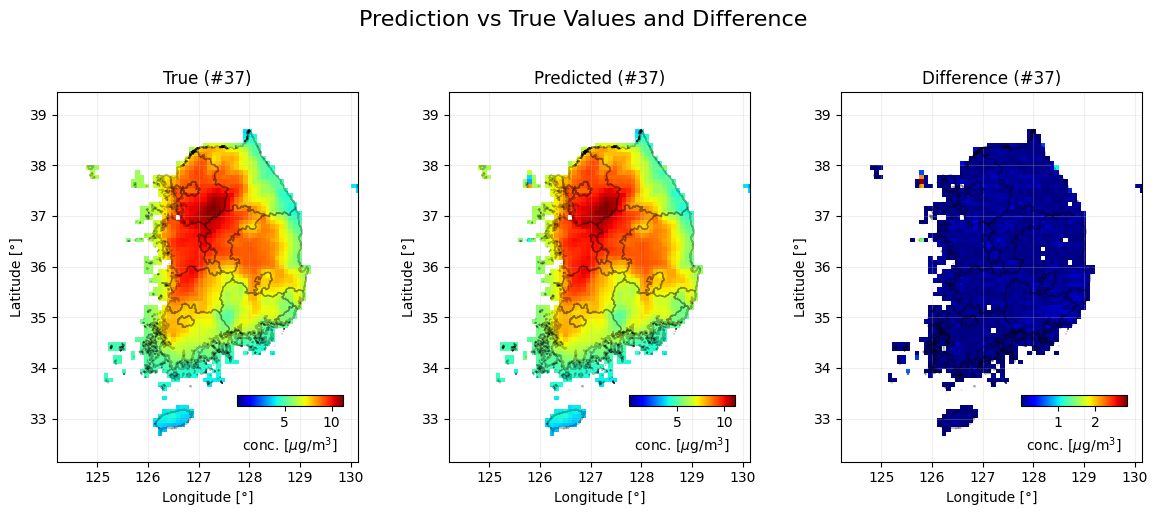

In [372]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=37)

[37]


/tmp/ipykernel_1931213/4034451116.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1931213/4034451116.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1931213/4034451116.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1931213/4034451116.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1931213/4034451116.py:67: UserWarning: set_ti

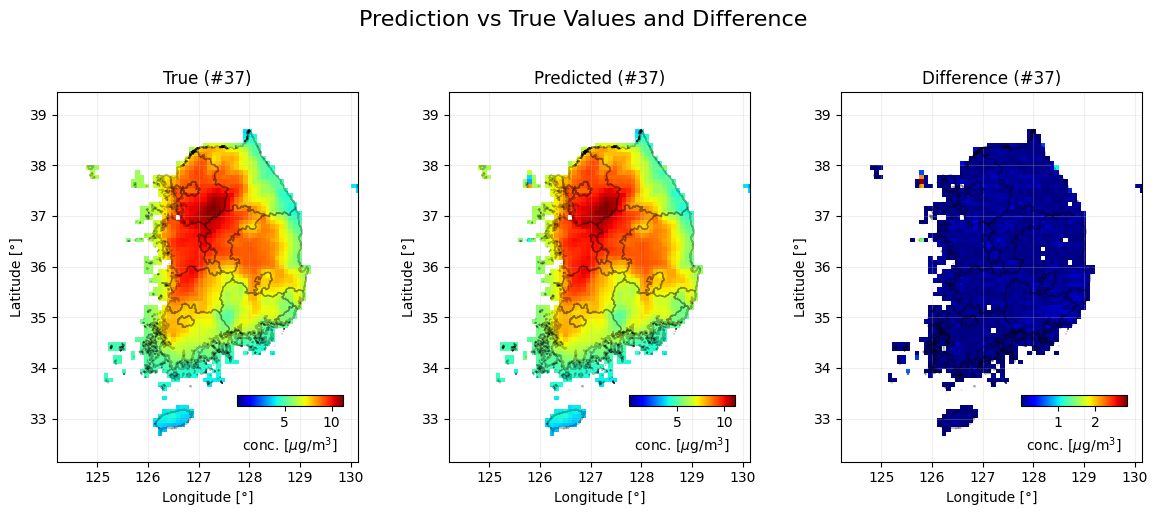

In [373]:
plot_prediction_loss(true_conc_map_w_lines, y_pred_restored, indices=37)

In [374]:
difference = np.abs(true_conc_map_w_lines[29] - pred_conc_map_w_lines[29])
new_diff = difference

/tmp/ipykernel_1931213/2595177862.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1931213/2595177862.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


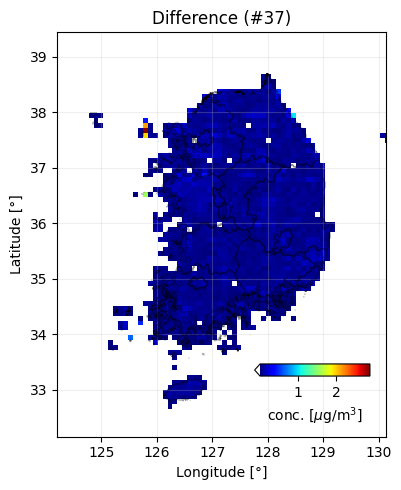

In [375]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.imshow(
    new_diff[::-1], 
    cmap=cmap_white,
    vmin=0.001,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    interpolation='none')
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.set_title(f"Difference (#{37})")
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)', extend='min')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')   
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=-0.4, hspace=0.2)
plt.show()

In [376]:
print("new_diff의 최소값:", new_diff.min())
print("new_diff의 최대값:", new_diff.max())
arr_below_001 = (new_diff < 0.001).sum()  # 0.001 미만 픽셀 개수
print("0.001 미만 픽셀 개수:", arr_below_001)

new_diff의 최소값: 0.0
new_diff의 최대값: 2.8805892
0.001 미만 픽셀 개수: 3921


In [377]:
for i in range(0, new_diff.shape[1]):
    print(f'----{i}----')
    print(new_diff[i])

----0----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----1----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----2----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----3----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----4----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [378]:
max_val = float('-inf')
max_row, max_col = None, None

for i, row in enumerate(new_diff):
    for j, val in enumerate(row):
        if val > max_val:
            max_val = val
            max_row, max_col = i, j

print("가장 큰 값:", max_val)
print(f"위치: (row={max_row}, col={max_col})")
new_diff[max_row][:] = 0

가장 큰 값: 2.8805892
위치: (row=61, col=17)


/tmp/ipykernel_1931213/3064549709.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1931213/3064549709.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


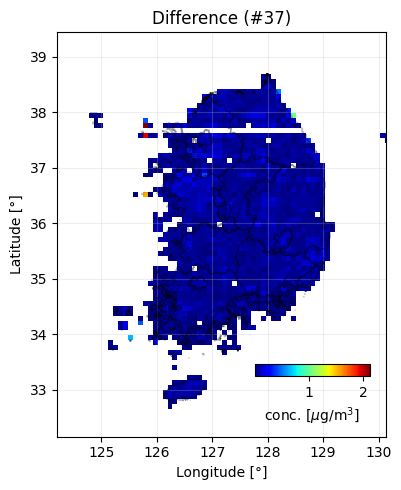

In [379]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.imshow(
    new_diff[::-1], 
    cmap=cmap_white,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    vmin=0.001, interpolation='nearest')
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.set_title(f"Difference (#{37})")
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')   
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=-0.4, hspace=0.2)
plt.show()